[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kasparvonbeelen/ghi_python/4-tables?labpath=11_-_Linear_Regression.ipynb)


# Lecture 11: Linear Regression
## A gentle introduction to correlation and regression for historians 
### ... in Python and Pandas


## Data Science for Historians (with Python)

### Created by Kaspar Beelen and Luke Blaxill

### For the German Historical Institute, London

<img align="left" src="https://www.ghil.ac.uk/typo3conf/ext/wacon_ghil/Resources/Public/Images/institute_icon_small.png">



This notebook turns to more advanced and scientifically interesting methods. We will discuss linear regression and later on generalised linear models. 

So far, we focused on quantifying and interpreting differences between subgroups in our data (place and gender), more specifically estimating the significance between the means.


Now we turn the analysing the relationship between variables, the extent to which variables are associated with each other. This allows us to model historical phenomena and make predictions. 

As in the previous notebook, we highly recommend you watch the lecture by Luke Blaxill for an introduction to the concepts and terminology used in this lecture.

## Understanding relations between variables: Lifespan and Wealth in late Victorian London

We continue with the data used previously but change the research question and analyse the relationship between wealth and lifespan. Concretely, we will asess if the wealthier districts causes a higher ratio of older people. We don't have information on the possession or income for each individual but we have access to the rateable value per capita for each borough in London, which serves as a proxy for the average prosperity of place. We will abbreviate this variable as `rvc` in what follows. 

When it comes to lifespan we use the same synthetic census data as in notebook ten. We don't have information on how long people live, but we can establish the ratio of 'old' people, for example, those aged over 50. 

Notice how both variables (wealth and lifespan) are proxies for concepts we can not measure directly. In many ways, this makes this case study highly problematic (but therefore morer useful from a didactic perspective). However, working with imperfect proxies is often the only option and being creative with your data is a necessity. In the social sciences, the operationalisation of your research is called [construct validity](https://en.wikipedia.org/wiki/Construct_validity): as we project meaning onto our data we should be critical of our semantics.



Let's turn to our code. The first step is to load the required tools we need later on in this notebook.

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import matplotlib.pyplot as plt
sns.set()

Before turning to the actual regression analysis, we need to discuss the data wrangling. We will cover a few steps that you will often encounter when preparing your data for analysis.

We create a new dataframe that records the ratio of people over 50 for each district. 

Why? We don't know how long Londoners live on average. Here we reason that districts where people have a higher probability of getting "old" (beyond 50) they tend to live longer. For "old", we computed the ratio of residents over 50 years (twice the median) but we could have chosen other thresholds. We encourage you to do this and assess the extent to which the results will change.

In [20]:
df = pd.read_csv('data/icem/EW01_london_subsample.csv',index_col=0)
df.head()

,RegDist,Sex,Age,Disability
0,Kensington,M,18,0
1,Greenwich,U,14,0
2,St George Hanover Square,M,38,0
3,St Olave Southwark,F,42,0
4,St George Hanover Square,M,19,0


In [21]:
df.Age.mean(), df.Age.median()

(27.786728095422067, 25.0)

In [22]:
#age_by_dist = df.groupby(['RegDist']).agg({'Age':'mean','Sex':'count'})

In [23]:
age_by_dist = df.groupby(['RegDist']).agg({'Age':lambda x: np.mean(x > 50),'Sex':'count'})

In [24]:
age_by_dist

,Age,Sex
RegDist,,
Bethnal Green,0.117463,31593
Camberwell,0.131304,63060
Chelsea,0.171204,18329
Fulham,0.123097,60489
Greenwich,0.126405,44832
Hackney,0.138932,65687
Hampstead,0.134613,20117
Holborn,0.125383,31320
Islington,0.138770,81826


To understand the relationship between average wealth and lifespan we need to add additional information to our dataframe. 

The dataframe below capture the rateable value per capita in each London borough (these data are synthetic but follow the pattern of  "real" values collected for 1922).

In [31]:
rvc = pd.read_csv('./data/icem/rateable_value.csv',index_col=0)
rvc.head()

,borough,rateable_value_pc
0,Battersea,6.1
1,Bermondsey,8.5
2,Bethnal Green,4.9
3,Camberwell,5.2
4,Chelsea,14.7


We want to merge the data frames, but first, we should check to what extent this is possible, both practically and theoretically.

Our first question is: What variables occur in both datasets? Which ones can we use to combine information from different sources?

For our data, both data frames have information about place. The census lists registration districts while the rateable value is organised by the borough.

This leads to a second question: To what extent are the districts that appear in the census the same as the boroughs in the data on rateable value per capita?

First we want check which place names appear in both datasets. We create a Python `set`, a list of unique values, for the place names in both dataframes.


In [27]:
d1_pl = set(df['RegDist'])
print(d1_pl)

{'Hampstead', 'St Giles', 'Fulham', 'Kensington', 'Pancras', 'Holborn', 'Poplar', 'London City', 'Islington', 'St George Hanover Square', 'Lewisham', 'Wandsworth', 'St Olave Southwark', 'Hackney', 'Greenwich', 'Woolwich', 'St George In The East', 'Bethnal Green', 'Marylebone', 'Chelsea', 'Westminster', 'Whitechapel', 'Southwark', 'Strand', 'Paddington', 'Lambeth', 'Shoreditch', 'Mile End Old Town', 'Stepney', 'Camberwell'}


In [32]:
d2_pl = set(rvc['borough'])
print(d2_pl)

{'Battersea', 'Hampstead', 'Fulham', 'Kensington', 'Holborn', 'Pancras', 'Poplar', 'Islington', 'Lewisham', 'Wandsworth', 'Finsbury', 'Bermondsey', 'Hackney', 'Hammersmith', 'Greenwich', 'Woolwich', 'Bethnal Green', 'Stepney', 'Marylebone', 'Chelsea', 'Stoke Newington', 'Westminster', 'Southwark', 'Paddington', 'Lambeth', 'Shoreditch', 'Deptford', 'Camberwell'}


We then compute the intersection of these two sets, i.e. the names that appear in both dataframes.

The syntax is `set1.intersection(set2)`. We basically apply the `.intersection()` to a set and pass another set as argument.

In [33]:
print(d1_pl.intersection(d2_pl)) # place names that appear in both dataframes

{'Hampstead', 'Fulham', 'Kensington', 'Holborn', 'Pancras', 'Poplar', 'Islington', 'Lewisham', 'Wandsworth', 'Hackney', 'Greenwich', 'Woolwich', 'Bethnal Green', 'Marylebone', 'Chelsea', 'Westminster', 'Southwark', 'Paddington', 'Lambeth', 'Shoreditch', 'Stepney', 'Camberwell'}


In [30]:
d1_pl - d2_pl # place names that appear in df and not rvc

{'London City',
 'Mile End Old Town',
 'St George Hanover Square',
 'St George In The East',
 'St Giles',
 'St Olave Southwark',
 'Strand',
 'Whitechapel'}

In [34]:
d2_pl - d1_pl # place names that appear in rvc and not in df

{'Battersea',
 'Bermondsey',
 'Deptford',
 'Finsbury',
 'Hammersmith',
 'Stoke Newington'}

We can merge these two data frame based on the place names. However, be careful: it is not because the strings match that they mean the same thing!

Don't worry about the syntax we will explain it in more detail below.

In [36]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,Sex,borough,rateable_value_pc
2,0.117463,31593,Bethnal Green,4.9
3,0.131304,63060,Camberwell,5.2
4,0.171204,18329,Chelsea,14.7
7,0.123097,60489,Fulham,6.1
8,0.126405,44832,Greenwich,7.6
9,0.138932,65687,Hackney,5.7
11,0.134613,20117,Hampstead,13.3
12,0.125383,31320,Holborn,32.0
13,0.138770,81826,Islington,5.7
14,0.152105,43115,Kensington,14.4


`.merge()` is an extremely useful method combining data frames. It requires us to specify which variable (or column) is shared across data frames and can be used for merging tables. 


In this `.merge()` operation, we combined information from `rvc` with `age_by_dist`. 

As we have shown before, both data frames contain a column with similar values, namely, place names in London. 

We use these values to combine the data frames, i.e. rows that have the value `Bethnal Green` in the `age_by_dist` data frames will be joined by the information we have for 'Bethnal Green' in `rvc`

Please notice: the names of the columns can be different but the values in the columns have to overlap.

Below we show a toy example slight adapted from very thorough Pandas [documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

Imagine that I recorded the number of cats and dogs I spotted each day, but kept this information in two separate data frames.

In [37]:
df1 = pd.DataFrame({'day': ['mon', 'tue', 'wed', 'thu'],
                    'cats': [1, 2, 3, 5]})
df2 = pd.DataFrame({'dayz': ['mon', 'tue', 'wed', 'thu'],
                    'dogs': [5, 6, 7, 8]})

In [38]:
df1

,day,cats
0,mon,1
1,tue,2
2,wed,3
3,thu,5


In [39]:
df2

,dayz,dogs
0,mon,5
1,tue,6
2,wed,7
3,thu,8


Both tables have a column that records that day of the week, even though the column name is slightly differentz. We can combine these data frames into one using `left_df.merge(right_df)`. The method is applied to a dataframe at the left-hand side (before the dot) and one at the right-hand side (passed as an argument to the method).

To merge properly, we have to instruct Pandas precisely which columns we want to use for combining information. `left_on` (`right_on`) indicates the column name we use in the dataframe at the left-hand (right-hand) side of the `.merge()` method. 

In [41]:
df1.merge(df2, left_on='day', right_on='dayz')

,day,cats,dayz,dogs
0,mon,1,mon,5
1,tue,2,tue,6
2,wed,3,wed,7
3,thu,5,thu,8


Sometimes we want `.merge()` using the index of a data frame instead of a column. In this case, we select the argument `left_index` (or `right_index`) and which takes a boolean value (`True` or `False`).

The `.merge()` operation should be more understandable at this point: we merge `age_by_dist` (left) with `rvc`. For the left data frame we use the index (`left_index=True`), for the right the `'borough'` column  (`right_on='borough'`).

In [44]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,Sex,borough,rateable_value_pc
2,0.117463,31593,Bethnal Green,4.9
3,0.131304,63060,Camberwell,5.2
4,0.171204,18329,Chelsea,14.7
7,0.123097,60489,Fulham,6.1
8,0.126405,44832,Greenwich,7.6
9,0.138932,65687,Hackney,5.7
11,0.134613,20117,Hampstead,13.3
12,0.125383,31320,Holborn,32.0
13,0.138770,81826,Islington,5.7
14,0.152105,43115,Kensington,14.4


##  Correlation

After combining information from these two data frames, we can explore the relationship between variables. Let's start with the most obvious: correlation. 

Correlation tells us the extent to which two variables are related. Imagine, each day I collect the number of dogs and cats I observed in two separate variables or vectors (`dogs` and `cats`). 

If there is a correlation, I expect that if the number of (spotted) dogs up, the same will apply to cats.

Visually, we can make a scatterplot to assess whether there is a correlation: the x-axis shows the number of dogs, the y-axis the number of cats. 

In [50]:
dogs = [1,3,5,7,2,6] # first vector
cats = [2,4,8,7,3,5] # second vector

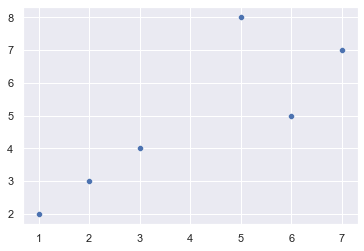

In [51]:
sns.scatterplot(x=dogs,y=cats)

The figure suggests a strong correlation between the vectors for`dogs` and `cats`, i.e. we observe high values for y when x is high (and vice versa of course). 

Please notice that computing correlation is based on an implicit alignment between the two vectors. Each position captures the same day. If the order in `cats` would be different from `dogs` (for example the former starts on Wednesday and the latter on Sunday) I could, technically, still make a scatterplot and computer correlation but the results would be meaningless (or at least not match the intention).

The visualization is helpful, but we'd like to put a number on this, quantify the strength of the relation, so we can compare if other vectors are stronger correlated. Here the Pearson correlation coefficient will come to our rescue.




### Pearson Correlation

A widely used measure for computing the relationship between two vectors or vectors is the Pearson correlation coefficient. This coefficient will vary between -1 and +1, meaning a strong negative respectively positive correlation. A score of 0 indicates no correlation.

We will first show you how to compute the Pearson correlation coefficient yourself, purely for didactic purposes, so you know what is going on (the score is not magic, far from!). But as you can probably guess by this point, there exists a method in Pandas that will help you. We'll have a look at that later.

Showing how the calculation is done, demystifies the process and helps you to understand what is going on.

We need a few ingredients to compute the Pearson correlation coefficient. First, we calculate the mean and standard deviation for each vector. We need to normalize by the amount of data we have and record the number of observations  `n`, which is equal to the length of `v1` (or `v2`—remember both are aligned and equal in length!).

In [70]:
v1 = [1,3,5,7,2,6] # first vector
v2 = [2,4,8,7,3,5] # second vector

In [71]:
mean_v1 = np.mean(v1)
mean_v2 = np.mean(v2)
std_v1 = np.std(v1)
std_v2 = np.std(v2)
n = len(v1)

Next, we subtract each value a vector with the mean (of that vector of course). We repeat this for `v1` and `v2`.

In [72]:
sub_mean_v1 = [i - mean_v1 for i in v1]
sub_mean_v2 = [i - mean_v2 for i in v2]

In [73]:
sub_mean_v1,sub_mean_v2

([-3.0, -1.0, 1.0, 3.0, -2.0, 2.0],
 [-2.833333333333333,
  -0.833333333333333,
  3.166666666666667,
  2.166666666666667,
  -1.833333333333333,
  0.16666666666666696])

Then we compute products of the values in `sub_mean_v1` and `sub_mean_v2` position-wise, i.e we multiply the first value in `sub_mean_v1` with first the value `sub_mean_v2` etc.

A convenient function for doing this `zip()`, which, as the name suggests, "zips" two lists based on their positional index. For example if we `zip` `sub_mean_v1` and `sub_mean_v1` we get:

In [74]:
diffs_zipped = list(zip(sub_mean_v1,sub_mean_v2))
diffs_zipped

[(-3.0, -2.833333333333333),
 (-1.0, -0.833333333333333),
 (1.0, 3.166666666666667),
 (3.0, 2.166666666666667),
 (-2.0, -1.833333333333333),
 (2.0, 0.16666666666666696)]

Each element in the list `diffs_zipped` is a tuple. We multiply the elements in each tuple..

In [75]:
products = [i*j for i,j in diffs_zipped]
products

[8.5,
 0.833333333333333,
 3.166666666666667,
 6.500000000000001,
 3.666666666666666,
 0.3333333333333339]


... and we sum all the values, which will give is the nominator of Pearson correlation coefficient.

In [76]:
nominator = sum(products)
nominator

23.0

To obtain the coefficient, we divide the nominator by the product of the standard deviations and the number of observations.

In [77]:
denominator = std_v1 * std_v2 * len(v1)

In [78]:
nominator / denominator

0.8390957231764806

Looking closer at these steps you can intuitively grasp what determines the strength of the correlation. If two values (at the same position) differ from the mean in equal terms, this will result in a higher product (remember from high school that the product of two negative numbers is positive!) and, in turn, increases the value of the nominator. 

Of course, Pandas provides a method called`.corr()` to compute correlations between two instances of `pd.Series`. We first convert each vector to an instance of `pd.Series` and then calculate the correlation coefficient, which, no surprise, should be exactly the same!

In [79]:
pd.Series(v1).corr(pd.Series(v2))

0.8390957231764807

Of course, now we can also compute the relation between age and wealth.

In [80]:
data_merged['Age'].corr(data_merged['rateable_value_pc'])

0.03575731342455902

Actually, that's quite a low correlation! This does not bode well for our expectation that richer boroughs are associated with longer lifespans. But we'll turn that to that shortly.

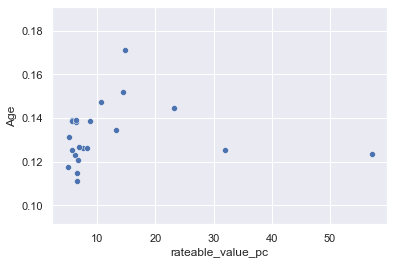

In [81]:
sns.scatterplot(x='rateable_value_pc',y='Age',data=data_merged)

### Spearman Correlation

Pearson correlation is one option of many to compute the strength of the relationship between two variables. The choice depends on your research priorities and some procedures will be more relevant or valid than others. 

Pearson takes into account the absolute counts of the number of cats and dogs. But imagine, that I don't care about how many animals I observe each day what matters is that ranking of the days is correlated. In this case, the ranking of the days has priority. In this scenario, we should calculate the Spearman rank correlation.  

To obtain this coefficient, we need to compute the rank of each day, for example, the third item in `v1` has rank 4 (i.e. it comes fourth after the items on positions 0, 1 and 4)

In [86]:
v1_ranked = {v:i+1 for i,v in enumerate(sorted(v1))} # compute the rank if each days
v1_rank = [v1_ranked[i] for i in v1]
v1, v1_rank 

([1, 3, 5, 7, 2, 6], [1, 3, 4, 6, 2, 5])

In [87]:
v2_ranked = {v:i+1 for i,v in enumerate(sorted(v2))} # compute the rank if each days
v2_rank = [v2_ranked[i] for i in v2]
v2, v2_rank

([2, 4, 8, 7, 3, 5], [1, 3, 6, 5, 2, 4])

In [89]:
mean_v1 = np.mean(v1_rank) # we compute the mean ranks
mean_v2 = np.mean(v2_rank)

In [99]:
nominator = np.sum([(i1 - mean_v1)*(i2 - mean_v2) for i1,i2 in zip(v1_rank,v2_rank)]) # we compute the difference between rank and mean rank

In [100]:
denominator = np.std(v1_rank) * np.std(v2_rank) * len(v2_rank)

In [101]:
nominator/denominator

0.8285714285714286

In [102]:
pd.Series(v1).corr(pd.Series(v2), method='spearman')

0.8285714285714287

In [103]:
data_merged['Age'].corr(data_merged['rateable_value_pc'],method='spearman')

0.2843416175645498

Correlation does not mean causation. Oftentimes, correlations are 'spurious', i.e. it is unlikely there exists a realistic mechanism that explains the association between two variables. 
 
There is even [a website on this topic!](https://www.tylervigen.com/spurious-correlations)

Be careful when making claims based on correlation. As often, the statistical experiment won't give you an answer to your question. There is no simple way to determine if a correlation is spurious. It depends on your domain expertise to make sense of these results and justify them.


# Linear Regression

Whereas correlation tells you that two variables, X and Y, are related (albeit in a very superficial way) you can not model their relationship: you can not predict Y using X (you only know that when X goes up, Y goes up, seeing more dogs implies more cats to gaze at).

Regression modelling, on the other hand, attempts to model the mechanistic relationship between two variables: how many cats do I expect to see, given that I observed 5 dogs?

Modelling the mechanistic relationship allows us to predict phenomena based on a number of what are usually called independent predictor variables.

Returning to our example of age and wealth (goodbye doggies, you were very helpful), we'd like to see if we can predict the average age (response) in a district given the rateable value per capita (predictor).

Notice here that we have to rely on common sense and domain expertise to construct a model that makes sense. We could also model the reverse, assuming that populating an area with younger people will affect rateable value. Of course, that also makes sense in some universe and could be called reverse causality. 

However, in the way we framed the research (and again this a construction and based on construct validity) we framed as wealth having an impact on age: in poor district the people die younger, people dying younger doesn't make a place poorer. 

R -> A

and not 

R <- A

But these are assumptions, (questionable) projections on the data. Oftentimes, when reading a historical paper that uses statistical methods, it is often more important to critically look at the relation between narrative and method (what is data supposed to capture (or mean) and how is combined into a causal theory).

Let's first discuss what a regression model does, before we continue with a more detailed discussion on how to run a regression model.

In it's simplest form a linear model we try to predict a value (age) based on a linear combination of another valie (rateable value per capita). We want to predict the former using the latter.

Using `seaborn` we can make a dispersion plot where each observation is turned into a point on the figure. The x-axis (`x=`) shows the rateable value, the y-axis (`y=`) age. 

In [ ]:
sns.scatterplot(x='rateable_value_pc',
                y='Age',
                data=data_merged)

How? Looking at the scatterplot the relation between the two is not obvious. In it's simplest, a linear regression will model the relation between x and y by drawing a line best "fits" the data, i.e. closest to the observations as possible.

From your high school you may remember the equation of a line.

y = a + b*x

age = intercept + slope * rateable value per capita

a is intercept, the point where the line crosses to y-axis if x is zero. You may also think as: what age do we expect for a place with zero rateable value.

b is the slope, and determinss the strength the y and x: how much change to we expect in y after one unit change x. What how many years do we expect to add moving from a place with rateable value 3 to 4 for example.

We know age and rateable value. We use these data to estimate the value of a (intercept) and b slope. We have a closer look at this later.

For now we plot the result, i.e. what the model thinks the line should look like after observing the data.

In [ ]:
sns.regplot(x="rateable_value_pc", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

The line plotted is based on a linear regression and is the line that fits best all observations. 

The fact that models "work", doesn't nesicarilly mean they make sense. A best fit can still be pretty bad.

As you observe there are many values cluttered together in the lower range and only a few at the right hand side of the figure.

We can improve the fit by transforming the values on a-axis. We take the natural logarthim of the rateable value per capite, this will make small differences (pull apart the observation at the lower end of independent variable) and large difference smaller (push those places at the far right to the other observations).

But what is the natural logarithm? Let's have a look, what happens if we take the logarithm of 1000

In [ ]:
np.log(1000)

We get a number close to 7 (i.e. 6.907755278982137). What does this mean? The logarithm is inverse of exponentation: if x = log(y) and y = exp(x), or sticking to our example, if np.log(1000) produces 6.907755 then 
e<sup>6.90775</sup> will approximately equal 1000 (not exactly as rounded the numbers.
`e` is called Euler's number and is approximately equal to 2.71828182845904523536028747135266249775724709369995 according to [Wikipedia]. You can check this for yourself

In [ ]:
np.exp(6.907755278982137)

In [ ]:
np.power(2.71828,6.907755278982137)

But why we would we do this, why would we effectively rescale one our variables? This partly solves the problem of dispersion: the logarithmic scale can make linear modelling easier, as sometimes value becomes linear on a logarithmic scale. Below we first show a toy example using numbers that become increasingly separated.

In [ ]:
x_1 = [10,100,1000,10000]

As you seen it is very difficult to model sudden gaps with a linear line...

In [ ]:
sns.regplot(x=list(range(len(x_1))), y=x_1, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

However, if we take the logarith, these values become neatly linear.

In [ ]:
x_2 = np.log([10,100,1000,10000])

In [ ]:
sns.regplot(x=list(range(len(x_2))), y=x_2, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

Even though 'real' data never fits patterns as neatly, we observe similar changes when inspecting the rateable value per capita variable.

In [ ]:
data_merged.sort_values('rateable_value_pc',inplace=True)

In [ ]:
sns.regplot(x=list(range(22)), y=data_merged["rateable_value_pc"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

In [ ]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc'])

In [ ]:
sns.regplot(x=list(range(22)), y=data_merged["rvc_log"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Both lines don't fit the data perfectly, however the later one does seem approximate the actual observed values better.

Also, if now model age as a function of the logged rateable value, we 

In [ ]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc'])

In [ ]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Later in this lecture we have a closer look and actually quantify the difference logging makes with respect to the goodness of fit. For now, a visual inspection suffices. Even though, we could add, that logging also improved the correlation between the two variables.

In [ ]:
data_merged['rateable_value_pc'].corr(data_merged['Age'],method='pearson')

In [ ]:
data_merged['rvc_log'].corr(data_merged['Age'],method='pearson')

Generally logging values doesn't harm, but you'll have to be careful as it influences your interpretation and the predictions to model will make. So you have to be carefull nonetheless. 

A closer look at the scatterplot and the data shown that two (or three) places have a signficantly higher rateable value: Holborn and Westminster, and also Marelybone. This is confirmed by the boxplot below.  

How to approach these observation: one albeit, very problematich approach is to consider them as outlier and remove them from the datasets.

This is a classical example of where interventions need to motivated or at least explained by domain expertise. Excluding the Holborn and Westminster has a huge effect on the slope of the regression line.

In [ ]:
data_merged[['borough','rateable_value_pc']]

In [ ]:
sns.boxplot(data_merged.rateable_value_pc)

Let's remove these districts to how they affect our model.

In [ ]:
data_wo_outliers = data_merged[~data_merged.borough.isin(['Westminster',"Holborn"])]

In [ ]:
sns.regplot(x="rvc_log", y="Age", data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

sns.regplot(x="rvc_log", y="Age", data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

In the figure the orange line shows the regression line after removing the so-called 'outliers'. You see how throwing away information (i.e. observations) is tricky thing: yes it easier to model the relationship between the variables linearly. However, this comes at a cost, we won't be able to accurately say something about the wealthier districts, and (if we believe the orange 

However, if you're only interested in predicting the age for a certain type of boroughs, and have good reasons to believe the ones we throwns are qualitatively different and should be considered as seperate case studies, then yes, it could be allow the consider only certain boroughs.

In any case, it is important to know the a few place carry a lot of weight, i.e. the influence the slope of the regression lines substantially.


Again, here, or domain expertise has priority over statistics, and the statistics alone can not provide you with the answer of how to proceed and analyse your data.

In [ ]:
print(data_merged['rvc_log'].corr(data_merged['Age']))
print(data_wo_outliers['rvc_log'].corr(data_wo_outliers['Age']))


In [ ]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Hopefully, this largely visual introduction demonstrated the use of linear regression and some of problems that you are likely to encounter. Again, we'd like to stress that often the solution to these issues often require you to lean on your domain expertise as historian. To solutions are often not statistical. 

History always should come before statistics.

## Linear Regression (a closer look)

In the preceding section we approached the idea of linear regression from a more intuitive, visual perspective. In this section we have a closer look at the reading the results and outputs that accompany regression analysis. 

Performing a linear regression is rather straightforward with  the `statsmodels` package in Python. There a just a few things to be careful about. First we define the response variable, in this case 'Age'.

In [ ]:
Y = data_merged['Age']

Next we select the independent variable from the dataframe.

In [ ]:
X = data_merged['rateable_value_pc']

Now there is one small trick to keep in mind. As said earlier the equation of a simple linear model is 

$y = a + b*x$

In this equation we know both $y$ and $x$ these are data we observed. We don't know $a$ and $b$, these are the parameters we want to learn from the data. 

Running a regression will return an estimate for $a$ and $b$ most consistent with the observed data. 

Because we want `statsmodels` to estimate both the intercept $a$ and the slope $b$ we have to add one more column with only a constant to `X`. Luckily this is really straightforwards with the `add_constant` function.

In [ ]:
X = sm.add_constant(X)
X 

Now we are ready instantiate the model and fit it. We save the result of the fitted model in the `results` variable.

In [ ]:
model = sm.OLS(Y,X) # instantiate model
results = model.fit() # fit model

Applying the `.summary()` method to the fitted model will print a rather large report.

In [ ]:
results.summary()

Most import values (for our purposes) are at the top right and the midde lines that report on the coefficients (`const` and `rvc_log`). Let's start with the latter, as these are most influential in the interpretations based on regression modelling.


`const 27.4098` means that for place with zero rateable value, we expect the average age to be around 25.2. This is the estimate for the intercept, i.e. the value of y (Age) when x (rateable value) = 0. 
`rateable_value_pc 0.0429` this is an estimate of the slape, the increase in y for one unit change in y: for example if the rateable value changes from 1 to 2 we expect the mean age to increase with 0.04 years. 

Now let's look at the other statistics reported here for these coefficients. Continuing with the estimate for `rateable_value_pc` the p-value is around 0.1 higher than the traditional 0.5 threshold commonly used in statistics. And the confidence intervals range from -0.010 to 0.096. 

Notice that this 0 is included in the confidence interval. A slope of zero means a horizontal line, and actually no change in y for x. The possibiliy that x and y are not related in any positive or negative way is well within the range of possibilities.

p-values and confidence remain rather abstract and difficult to explain, and statisticians tend to doubt their use. In human language, these number tells you how confident the model is about where to draw a line to best fit all observed variables. It is really shore that the intercepts is higher than zero, which is not surprising and probably somewhere between `26.523`	`28.296`. 

However, it is less confident about the slope, which can go down (-0.010) as well as up (0.096).

What happens if we fit a new model with logged rateable values values.

In [ ]:
Y_2 = data_merged['Age']
X_2 = data_merged['rvc_log']
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(Y_2,X_2) # instantiate model
results_2 = model_2.fit() # fit model

In [ ]:
results_2.summary()

Using the log-scale, change coefficients quite a lot especially for the rateable value. The model is now more certain the relation is postive and does not include the zero in the range of possibilities. 

For each change in x (the log of rateable value) we expect to add one year and a bit to `y` (1.2195). It is now a bit more difficult to understand, as the absolute change is bigger with each step in `x`.

In [ ]:
np.exp(2), np.exp(3), np.exp(4)

This means that the model thinks that change in age is the same when going from a place with rateable value 7 to 20 as is transitioning from 20 to 54.

What all the statistics for the `const` and `rvc_log` are more formal ways for conveying where the model thinks the line should be.

We can make these results more intuitive using a "bootstrap" method. We construct the mean and confidence intervals repeatin the following steps, let's say 1000 times:
- sample a few observations from the data (50% in each iterations)
- fit the model and record the values for the intercept and the slope
- plot the line using these value or collect them and compute the 2.5 and 97.5 percentile range.

In [ ]:
#data_merged.sort_values('re',inplace=True)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
beta = []

for _ in range(1000):
    dms = data_merged.sample(frac=.66)
    Y_ = dms['Age']
    X_ = dms['rvc_log']
    X_ = sm.add_constant(X_)
    model_ = sm.OLS(Y_,X_)
    results_ = model_.fit() 
    beta.append(results_.params['rvc_log'])

    ax.plot(data_merged['rvc_log'], results_.params['const'] + (data_merged['rvc_log']*results_.params['rvc_log']) , '-g',alpha=.5)


In [ ]:
pd.Series(beta).plot(kind='density')
pd.Series(beta).quantile([.025,.975])

The values are not exactly the same because we have a small sample and only ran a few iterations. However it gives more intuitive way of understanding of what the p-values and confidence intervals mean. Instead of bootstrapping you can also compute the formula-based intervals with `statsmodels`.

In [ ]:
pred = results_2.get_prediction(X_2)
df_pred = pd.DataFrame(pred.conf_int())
df_pred['mean'] = pred.predicted_mean

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(data_merged['rvc_log'], 'Age',data=data_merged,alpha=.5)
ax.plot(data_merged['rvc_log'], df_pred['mean']  , '-ro',alpha=.75)
ax.plot(data_merged['rvc_log'], df_pred[0]  , '-g',alpha=.75)
ax.plot(data_merged['rvc_log'], df_pred[1]  , '-g',alpha=.75)

Please notice that coeficients and their confidence intervals are estimates of the line not the actual data. These are, as you can see, well outside the range given by the predicted values and their confidence intervals.

The `.summary()` method provides other statistics that help you understanding how well the model performs.

In [ ]:
results_2.summary()

`RMSE`

In [ ]:
pred = results_2.get_prediction(X_2)
Y_hat = pred.predicted_mean 
var_pred = [(y - y_hat)**2 for y,y_hat in zip(Y,Y_hat)] 

In [ ]:
Y_hat

`R-squared`

In [ ]:
np.sqrt(np.sum(var_pred) / len(Y))

In [ ]:
var_total = [(y - np.mean(Y))**2 for y,y_hat in zip(Y,Y_hat)] 

In [ ]:
round(1 - (sum(var_pred)/sum(var_total)),3)

In [ ]:
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(results)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.cooks_distance[0], influence.influence,
s=1000 * np.sqrt(influence.cooks_distance[0]),
alpha=0.5)
ax.set_xlabel('influence')
ax.set_ylabel('standardized residuals')

In [ ]:
data_merged.iloc[np.argmax(influence.hat_diag_factor)]

In [ ]:
Y_woo = data_wo_outliers['Age']
x_woo = data_wo_outliers['rvc_log']
#X_woo = np.column_stack((x_woo, np.log(data_wo_outliers['index'])))
X_woo = sm.add_constant(x_woo)
model_woo = sm.OLS(Y_woo,X_woo)
results_woo = model_woo.fit()

In [ ]:
results_woo.summary()

In [ ]:
data_wo_outliers.sort_values('rvc_log',inplace=True)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_wo_outliers)
beta = []
for _ in range(100):
    dms = data_wo_outliers.sample(frac=.5)
    Y = dms['Age']
    X = dms['rvc_log']
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit() 
    beta.append(results.params['rvc_log'])

    ax.plot(data_wo_outliers['rvc_log'], results.params['const'] + (data_wo_outliers['rvc_log']*results.params['rvc_log']) , '-g',alpha=.5)


In [ ]:
pd.Series(beta).plot(kind='hist',bins=25)
pd.Series(beta).quantile([.025,0.975])

In [ ]:
wo_outliers['predictions'] = results.predict(X)

In [ ]:
data_merged

In [ ]:
Y_mr = data_merged['Age']
x_mr = data_merged['rvc_log']
X_mr = np.column_stack((x_mr, np.log(data_merged['Sex'])))
X_mr = sm.add_constant(X_mr)
model_mr = sm.OLS(Y_mr,X_mr)
results_mr = model_mr.fit()

In [ ]:
results_mr.summary()

In [ ]:
data_merged['predictions'] = results_mr.predict(X_mr)

In [ ]:
len(predictions),len(data_merged)

In [ ]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
ax.scatter('rvc_log', 'predictions',data=data_merged)